In [1]:
from io import BytesIO

import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')

import hvplot.pandas

%opts magic unavailable (pyparsing cannot be imported)
%compositor magic unavailable (pyparsing cannot be imported)


In [2]:
import os
path = '../data'
files = os.listdir(path)
path_files = [path + '/'+ string for string in files]
file_entries = dict(zip(files,path_files))
file_entries

{'20220928-193156_JigsawPuzzle.csv': '../data/20220928-193156_JigsawPuzzle.csv',
 '20221003-131623_JigsawPuzzle.csv': '../data/20221003-131623_JigsawPuzzle.csv',
 '20220930-180439_JigsawPuzzle.csv': '../data/20220930-180439_JigsawPuzzle.csv',
 '20221003-134004_JigsawPuzzle.csv': '../data/20221003-134004_JigsawPuzzle.csv',
 '20221003-132953_JigsawPuzzle.csv': '../data/20221003-132953_JigsawPuzzle.csv',
 '20221003-132653_JigsawPuzzle.csv': '../data/20221003-132653_JigsawPuzzle.csv',
 '20221003-175958_JigsawPuzzle.csv': '../data/20221003-175958_JigsawPuzzle.csv',
 '20221004-114501_JigsawPuzzle.csv': '../data/20221004-114501_JigsawPuzzle.csv',
 '20221013-141842_JigsawPuzzle.csv': '../data/20221013-141842_JigsawPuzzle.csv',
 '20221020-150106_JigsawPuzzle.csv': '../data/20221020-150106_JigsawPuzzle.csv',
 '20221020-162555_JigsawPuzzle.csv': '../data/20221020-162555_JigsawPuzzle.csv',
 '20221020-162057_JigsawPuzzle.csv': '../data/20221020-162057_JigsawPuzzle.csv',
 '20221109-144049_JigsawPuzz

In [18]:
select = pn.widgets.Select(options=file_entries)

@pn.cache
def fetch_data(url):
    df = pd.read_csv(url)
    df.drop('time', axis = 1, inplace = True)
    df.insert(0,'time',df.index.values)
    df = df.fillna(0)
    return df

select_df = pn.Column(select, pn.bind(pn.widgets.Tabulator, pn.bind(fetch_data, select), page_size=10))

NameError: name 'pn' is not defined

In [22]:
@pn.cache
def fetch_size(url):
    df = pd.read_csv(url)
    return df.size

In [25]:
idf = hvplot.bind(fetch_data, select).interactive()
dir(idf)
idf.shape[0]

PNG(str)
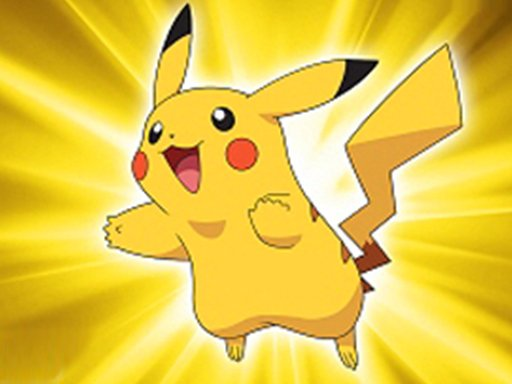

In [4]:
png_pane = pn.pane.PNG('./pictures/pikachu.png')
png_pane

## Slide to see only a region


In [31]:
time_slide_l = (
    pn.widgets.IntSlider(
        name = "Time slider",
        start = 0,
        end = 2724,
        value = 0,
        step = 1    )
)

In [32]:
 time_slide_r= (
    pn.widgets.IntSlider(
        name = "Time slider",
        start = 0,
        end = 2724,
        step = 1,
        value = 2724
        )
)

In [33]:
time_slide_l

IntSlider(end=2724, name='Time slider')

In [34]:
# Radio buttons for CO2 measures
yaxis_shoulder = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['shoulderLangle', 'shoulderRangle',],
    button_type='success'
)

In [35]:
time_slide_r_var = 1
dir(time_slide_l)

['_ContinuousSlider__abstract',
 '_ContinuousSlider__params',
 '_IntSlider__params',
 '_Layoutable__abstract',
 '_Layoutable__params',
 '_Parameterized__db_print',
 '_Parameterized__params',
 '_Reactive__abstract',
 '_Reactive__params',
 '_Renderable__abstract',
 '_Renderable__params',
 '_SliderBase__abstract',
 '_Syncable__abstract',
 '_Syncable__params',
 '_Viewable__params',
 '_Widget__abstract',
 '_Widget__params',
 '__SliderBase__params',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_location',
 '_add_parameter',
 '_apply_update',
 '_change_coroutine',
 '_change_event',
 '_changing',
 '_cleanup',
 '_com

In [41]:

shoulder_pipeline = (
    idf[(idf.time >= time_slide_l) &(idf.time <= time_slide_r) ])

In [42]:
shoulder_pipeline

In [43]:
shoulder_plot = shoulder_pipeline.hvplot(x = 'time',  y=yaxis_shoulder,line_width=2,  width=900, height=800, title="Shoulder Plot")
shoulder_plot


In [44]:
files = pn.widgets.FileSelector('../data')

In [14]:
#Layout using Template
template = pn.template.FastListTemplate(
    title='Wearable Device for Immersive Virtual Reality Control andApplication in Upper Limbs Motor Rehabilitation dashboard', 
    sidebar=[pn.pane.Markdown(""), 
             pn.pane.Markdown("#### Some meaningful instructions."), 
             select_df,
             pn.pane.PNG('device.png', sizing_mode='scale_both'),
             pn.pane.Markdown("## Settings"),   
            ],
    main=[pn.Row(pn.Column(yaxis_shoulder, time_slide_l, time_slide_r,
                           shoulder_plot.panel(width=700), margin=(0,25)), 
                  png_pane), 
          pn.Row(pn.Column(png_pane), 
                  png_pane)],
    accent_base_color="#87d8b0",
    header_background="#85d8b0",
)
# template.show()
template.servable();